_version log: Investigating the DCT_

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import patches
from PIL import Image
import pandas as pd
import os, re, sys
from scipy import interpolate as sciinter, signal as scisig, optimize as sciopt, ndimage as sciimage, fft as scifft #scipy has a lot of submodules
from astropy.io import fits
plt.rcParams.update({'font.size':14})
np.set_printoptions(threshold=sys.maxsize)

# Constants
c = 299_792_458 #m/s

In [4]:
##############GENERIC AND BASIC FUNCTIONS##############

def none2zero(x): #x should be an interger or None
    return int(x or bool(x)) #a simple if statement would work best but I think this is cooler.

def line(x,A,B):
    return A + B*x
     
def cubic(x,A,B,C,D):
     return A + B*x + C*x**2 + D*x**3

def cubic_residuals(x, y, A, B, C, D):
    return cubic(x, A, B, C, D) - y

def recip(x):
    return x #c*1e-6 / x #converts um to THz or vice versa. #1e4 / x # converts um to cm^-1 or vice versa. 

def format_ticks(x, pos):
    return f"{x:.1f}"  # Format the tick label with two decimal places

In [5]:
############FILE ORGANISATION FUNCTIONS#################

def find_fringes_files(colour, number, file_type):
    file_names = os.listdir("data\\")
    new_file_names=[]
    new_file_numbers=[]
    for file_name in file_names:
        check = re.findall('^'+colour+'_fringes'+number+'_*[0-9]*'+file_type , file_name)

        if len(check) != 0:
            new_file_names = new_file_names + [file_name]
            try:
                file_number = re.findall('_[0-9]+' , file_name)[0] #readings done with the delay line should look like this.
            except IndexError:
                file_number = "_0" #readings done without the delay line don't have a '_number' appendix.
            new_file_numbers = new_file_numbers + [int(file_number[1:])] #string indexing! Removes the '_' and saves the file number
    df = pd.DataFrame(np.transpose([new_file_names, new_file_numbers]), columns= ["file names", "file numbers"])
    df["file numbers"] = [int(number) for number in df["file numbers"]] #pandas forgot that numbers are intergers
    df = df.sort_values("file numbers", ignore_index= True) #I still don't know how to sort values using a key with numpy
    return df["file names"], df["file numbers"]

def combine_fringes_arrays(file_names, file_type):
    if file_type == ".tif" or file_type == ".tiff":
        im = Image.open('data\\'+file_names[0]) #for the first interferogram
        if im.mode == 'RGB': #The purple camera has colour channels dispite it being monochromatic.
            im = im.split()[0]
        angles = np.array(im, dtype= np.float32)
        for file_name in file_names[1:]: #for every other interferogram
            im = Image.open('data\\'+file_name)
            if im.mode == 'RGB':
                im = im.split()[0]
            Array = np.array(im, dtype= np.float32)
            angles = np.dstack([angles,Array])

    if file_type == ".csv":
        with open('data\\'+file_names[0], 'r') as file: #openai did this bit for me. It automatically detects which delimiter to use (pyro uses , xeva uses ;)
            first_line = file.readline()
            if ';' in first_line:
                delimiter = ';'
            else:
                delimiter = ','
        angles = np.genfromtxt('data\\'+file_names[0], dtype= np.float32, delimiter= delimiter, filling_values= 0)
        for file_name in file_names[1:]: #for every other interferogram
            Array = np.genfromtxt('data\\'+file_name, dtype= np.float32, delimiter= delimiter, filling_values= 0)
            angles = np.dstack([angles,Array])

    if file_type == ".fts":
        hdulist = fits.open('data\\'+file_names[0],  ignore_missing_end=True)
        angles = np.array(hdulist[0].data)
        hdulist.close()
        for file_name in file_names[1:]: #for every other interferogram
            hdulist = fits.open('data\\'+file_name,  ignore_missing_end=True)
            Array = np.array(hdulist[0].data)
            hdulist.close()
            angles = np.dstack([angles,Array])

    return angles  

def import_standard_photo(colour, number, file_type): #It would be nice to combine import_standard_photo and combine_fringes_arrays into a single function. They do basically the same thing.
    if file_type == ".tif" or file_type == ".tiff":
        im = Image.open('data\\'+colour+'_BA'+number+file_type)
        if im.mode == 'RGB': #The purple camera has colour channels dispite it being monochromatic.
            im = im.split()[0]
        beamA = np.array(im, dtype= np.float32)
        im.close()
        im = Image.open('data\\'+colour+'_BB'+number+file_type)
        if im.mode == 'RGB':
            im = im.split()[0]
        beamB = np.array(im, dtype= np.float32)
        im.close()
        im = Image.open('data\\'+colour+'_bg'+number+file_type)
        if im.mode == 'RGB':
            im = im.split()[0]
        background = np.array(im, dtype= np.float32)
        im.close()

    if file_type == ".csv":
        with open('data\\'+colour+'_BA'+number+file_type, 'r') as file: #openai did this bit for me. It automatically detects which delimiter to use (pyro uses , xeva uses ;)
            first_line = file.readline()
            if ';' in first_line:
                delimiter = ';'
            else:
                delimiter = ','
        beamA = np.genfromtxt('data\\'+colour+'_BA'+number+file_type, delimiter= delimiter, filling_values= 0)
        beamB = np.genfromtxt('data\\'+colour+'_BB'+number+file_type, delimiter= delimiter, filling_values= 0)
        background = np.genfromtxt('data\\'+colour+'_bg'+number+file_type, delimiter= delimiter, filling_values= 0)

    if file_type == ".fts":
        hdulist = fits.open('data\\'+colour+'_BA'+number+file_type,  ignore_missing_end=True)
        beamA = np.array(hdulist[0].data)
        hdulist.close()
        hdulist = fits.open('data\\'+colour+'_BB'+number+file_type,  ignore_missing_end=True)
        beamB = np.array(hdulist[0].data)
        hdulist.close()
        hdulist = fits.open('data\\'+colour+'_bg'+number+file_type,  ignore_missing_end=True)
        background = np.array(hdulist[0].data)
        hdulist.close()

    file_names, _ = find_fringes_files(colour= colour, number= number, file_type= file_type)
    fringes = combine_fringes_arrays(file_names= file_names, file_type= file_type)

    return fringes, beamA, beamB, background

def import_normalised_csv(file_name, start_row):
    File = open('data\\'+file_name, 'rt')
    array = np.loadtxt(File, skiprows=start_row, delimiter = ",")
    File.close()
    array[:,1] = array[:,1] / np.max(array[:,1]) #normalise
    return array

def pick_centered_interferogram(maximums_offsets, fringes, fringes_processed, fringes_averaged, nofringes, maximums, autopick= True):
    if autopick == True:
        reference_index = np.argmin(np.abs(maximums_offsets))
    else:
        reference_index = 0

    if fringes.ndim == 3:
        reference, reference_processed, reference_averaged, reference_offset, reference_nofringes = fringes[:,:,reference_index], fringes_processed[:,:,reference_index], fringes_averaged[:,reference_index], maximums_offsets[reference_index], nofringes[:,:,reference_index]
    elif fringes.ndim == 2: # only 1 fringes file found
        reference, reference_processed, reference_averaged, reference_offset, reference_nofringes = fringes, fringes_processed, fringes_averaged, maximums_offsets, nofringes

    return reference, reference_processed, reference_averaged, reference_offset, reference_nofringes


In [6]:
################2D INTERFEROGRAM FUNCTIONS#############

def dead_pixel_filter(interferogram, dead_pixels):
    # Remove the most anomalous 1% of pixels and replace with nearest nearbour.
    upper_percentile = 100 - dead_pixels/2
    lower_percentile = dead_pixels/2
    notdead = np.logical_and(interferogram <= np.percentile(interferogram,upper_percentile), interferogram >= np.percentile(interferogram,lower_percentile) )
    coords = np.mgrid[0:interferogram.shape[0], 0:interferogram.shape[1]]
    coords = np.moveaxis(coords, 0, -1) #refromat the array such that we have pairs of coordinates. ie. [[0,0],[0,1],[0,2]] ect.
    nearest = sciinter.NearestNDInterpolator(coords[notdead], interferogram[notdead])
    interferogram = nearest(coords[:,:,0],coords[:,:,1])

    return interferogram

def bg_subtract(fringes, beamA, beamB, background, dead_pixels= 0):
    if fringes.ndim == 3:
        nofringes = np.dstack([beamA +beamB -background] *fringes.shape[2]) #This will throw an error if fringes is 2d
        beamPost = fringes - nofringes #take away background.
        if bool(dead_pixels):
            for n in np.arange(0,beamPost.shape[2]):
                beamPost[:,:,n] = dead_pixel_filter(beamPost[:,:,n], dead_pixels) #I can't figure out how to vectorise this bit :/

        beamPost = np.subtract(beamPost, np.mean(beamPost, axis= (0,1)), casting= "safe")

    elif fringes.ndim == 2:
        nofringes = beamA +beamB -background #ignore the error
        beamPost = fringes - nofringes #take away background.
        if bool(dead_pixels):
            beamPost = dead_pixel_filter(beamPost, dead_pixels)
        beamPost = np.subtract(beamPost, np.mean(beamPost), casting= "safe")

    return beamPost, nofringes

def average_interferogram(interferogram_2D):
    interferogram_1D = np.mean(interferogram_2D, axis = 0)
    maximum,_ = find_best_peak(interferogram_1D) #find the center of the fringes
    maximums_offset = (interferogram_2D.shape[1]//2) - maximum #the center of the fringes might not be in the center of the image
    return interferogram_1D, maximum, maximums_offset

In [7]:
#################1D INTERFEROGRAM FUNCTIONS############

def find_best_peak(interferograms, height=None, threshold=None, distance=None, width=None, wlen=None, rel_height=0.5, plateau_size=None):
    if interferograms.ndim == 1:
        peaks, peaks_properties = scisig.find_peaks(interferograms, height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
        best_peak_index = np.argmax(peaks_properties["prominences"])
        peak = peaks[best_peak_index]
        peak_properties = {key: value[best_peak_index] for key, value in peaks_properties.items()}
    
    elif interferograms.ndim == 2:
        interferograms = interferograms.transpose() #Use the right set of axes.
        peaks, peaks_properties = scisig.find_peaks(interferograms[0], height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
        best_peak_index = np.argmax(peaks_properties["prominences"])
        peak = [peaks[best_peak_index]]
        peak_properties = {key: [value[best_peak_index]] for key, value in peaks_properties.items()}

        for interferogram in interferograms[1:]:
            peaks, peaks_properties = scisig.find_peaks(interferogram, height=height, threshold=threshold, distance=distance, prominence=0, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
            best_peak_index = np.argmax(peaks_properties["prominences"])
            peak = np.concatenate([peak, [peaks[best_peak_index]]])
            peak_properties = {key: peak_properties[key] +[value[best_peak_index]] for key, value in peaks_properties.items()}

    else:
        raise IndexError("find_best_peak expected interferograms to have 1 or 2 dimentions. Got {0:}".format(interferograms.ndim))
    return peak, peak_properties

def zero_pad(interferogram, zero_padding):
    original_length = len(interferogram)
    interferogram = np.concatenate([[interferogram[0]] *int((zero_padding-1) *original_length //2), interferogram])
    interferogram = np.concatenate([interferogram, [interferogram[-1]] *int((zero_padding-1) *original_length //2)])
    return interferogram

def apodization(interferogram = None, max_index = None, function = None, L = None, zero_padding = 1): #TO DO: rethink this
    '''
    Args:
        interferogram (1d np.array) = None: Leave blank to see apodization function.
        max_index (int) = None: Index that the apodization will be centered around. Defults to center of interferogram.
        function (list or str) = None: Available apodization functions include, boxcar, crop, triangular, happ-genzel, blackmann-harris, forward_ramp, backward_ramp, high_pass. None is equvelent to y=1 for all x.
        L (int) = None: length of interferogram before zero-padding. Defults to len(interferogram).
        zero_padding (float) = 1: How many times longer the zero-padded interferogram is from the original.

    Returns:
        interferogram (1d np.array): Apodized interferogram.
    '''
    if interferogram is None:
        interferogram = np.ones(1000) #This might seem a bit redundant but it is useful for viewing the apodization function. 

    # Setting defult values of L and max_index
    if L != None and max_index != None:
        max_index += (zero_padding-1) *L //2 # because the interferogram has been extended, the max_index has changed.
    elif L != None and max_index == None:
        max_index = L//2 + (zero_padding-1) *L //2
    elif L == None and max_index != None:
        L = len(interferogram)
    else: #L == None and max_index == None:
        L = len(interferogram)
        max_index = L//2

    index = np.arange(0, len(interferogram)) # We need indexes if we want to apply apodization
    function = list(pd.Series(function)) # 0d -> 1d. 1d -> 1d.

    if None in function:
        interferogram = interferogram # leave unchanged
    if "boxcar" in function:
        boxcar_function = [1 if i >= (zero_padding-1) *L //2 and i < (zero_padding+1) *L //2 else 0 for i in index] # apply boundries. interferogram is invalid in zero-padded regions.
        boxcar_function = np.array(boxcar_function)
        interferogram = interferogram * boxcar_function
    if "crop" in function:
        is_positive, is_negative = interferogram>=0, interferogram<0
        becomes_negative = np.logical_and(is_negative, np.roll(is_positive, 1))
        becomes_postive = np.logical_and(np.roll(is_negative, 1), is_positive)
        change_sign = np.logical_or(becomes_negative, becomes_postive)
        change_sign_indexes = np.arange(0,len(interferogram))[change_sign]
        start_index = change_sign_indexes[0]
        end_index = change_sign_indexes[-1]
        crop_function = [1 if i >= start_index and i < end_index else 0 for i in index] # apply boundries. interferogram is invalid beyond where it crosses zero.
        crop_function = np.array(crop_function)
        interferogram = interferogram * crop_function
    if "triangular" in function:
        triangular_function = 1 - np.abs(2/L *(index-max_index)) #definition of function
        triangular_function = [y if y >= 0 else 0 for y in triangular_function] #apply boundries. Negative values are invalid.
        triangular_function = np.array(triangular_function)
        interferogram = interferogram * triangular_function
    if "happ-genzel" in function:
        happ_genzel_function = 0.54 +0.46*np.cos(2*np.pi/L *(index-max_index)) #definition of function
        happ_genzel_function = [happ_genzel_function[i] if 2*(i-max_index)/L >= -1 and 2*(i-max_index)/L <= 1 else 0.08 for i in index] #apply boundries. Only the first period of the cosine is valid.
        happ_genzel_function = np.array(happ_genzel_function)
        interferogram = interferogram * happ_genzel_function
    if "blackmann-harris" in function:
        blackmann_harris_function = 0.42323 +0.49755*np.cos(2*np.pi/L *(index-max_index)) +0.07922*np.cos(4*np.pi/L *(index-max_index)) #definition of function. This is the 3-term blackmann-harris.
        blackmann_harris_function = [blackmann_harris_function[i] if 2*(i-max_index)/L >= -1 and 2*(i-max_index)/L <= 1 else 0.0049 for i in index] #apply boundries. Only the first period of the cosine is valid.
        blackmann_harris_function = np.array(blackmann_harris_function)
        interferogram = interferogram * blackmann_harris_function
    if "forward_ramp" in function:
        forward_ramp_function = (index -max_index)/L +0.5 #definition of function.
        forward_ramp_function = [0 if y < 0 else y for y in forward_ramp_function] #apply boundries. Values must be between 0 and 1.
        forward_ramp_function = [1 if y > 1 else y for y in forward_ramp_function] #apply boundries. Values must be between 0 and 1.
        forward_ramp_function = np.array(forward_ramp_function)
        interferogram = interferogram * forward_ramp_function
    if "backward_ramp" in function:
        backward_ramp_function = (max_index -index)/L +0.5 #definition of function.
        backward_ramp_function = [0 if y < 0 else y for y in backward_ramp_function] #apply boundries. Values must be between 0 and 1.
        backward_ramp_function = [1 if y > 1 else y for y in backward_ramp_function] #apply boundries. Values must be between 0 and 1.
        backward_ramp_function = np.array(backward_ramp_function)
        interferogram = interferogram * backward_ramp_function
    if "high_pass" in function: #I'm stretching the definition of apodization here
        FFT = np.fft.fft(interferogram, norm = "forward")
        threshold = len(FFT) //100
        FFT2 = np.zeros(FFT.shape, dtype= np.complex128)
        FFT2[threshold:-threshold] = FFT[threshold:-threshold]
        interferogram= np.fft.ifft(FFT2, norm = "forward").real

    return interferogram

def estimate_best_S2N(interferogram_averaged, fringe_width_estimate = 50):
    df = pd.DataFrame(interferogram_averaged, columns= ["interferogram"])

    peak_index, peak_properties = scisig.find_peaks(df["interferogram"], height= -np.Infinity, distance= fringe_width_estimate)
    df.loc[peak_index, "max"] = peak_properties["peak_heights"]
    df["max"].interpolate(inplace=True)
    peak_index, peak_properties = scisig.find_peaks(-df["interferogram"], height= -np.Infinity, distance= fringe_width_estimate)
    df.loc[peak_index, "min"] = -peak_properties["peak_heights"]
    df["min"].interpolate(inplace=True)

    df["range"] = df["max"] - df["min"]

    peak_index, _ = find_best_peak(df["range"], height = 0, width = 0, rel_height= 0.9)

    return peak_index, df["range"][peak_index]

def delay_line_angle(interferograms_averaged, interferograms_maximums, delay_line_delta, pixel_pitch, delay_line_bounds = [1, -1]):

    delay_line_travel = np.arange(interferograms_averaged.shape[1]) *delay_line_delta
    time_delay = delay_line_travel *2 /c
    time_delay *= 1e9 #convert from us to fs

    #we found the maximums earlier

    all_peak_estimates = interferograms_maximums[delay_line_bounds[0]:delay_line_bounds[1]]
    time_delays = time_delay[delay_line_bounds[0]:delay_line_bounds[1]]

    popt, pcov = sciopt.curve_fit(line, all_peak_estimates, time_delays)

    m = popt[1]
    m /= 1e9 *pixel_pitch #convert the gradient from fs/pixel to us/um (= s/m)
    theta = np.arcsin(c *np.abs(m) /2 ) 

    return theta

In [8]:
#################FFT FUNCTIONS#################

def angular_slice(phi, FT2ds, pixel_pitch): #THIS IS STILL KINDA RUBBISH. PLS IMPROVE.

    angle_of_diagonal = np.tan(FT2ds.shape[0] / FT2ds.shape[1])
    n = phi // np.pi #We need the angle to be between -pi < phi < pi

    x_center = (FT2ds.shape[1]//2 +0.5) * (1/(FT2ds.shape[1] *pixel_pitch)) #um^-1
    y_center = (FT2ds.shape[0]//2 +0.5) * (1/(FT2ds.shape[0] *pixel_pitch)) #um^-1

    if np.pi -np.abs(angle_of_diagonal) +np.pi*n < phi and np.abs(angle_of_diagonal) +np.pi*n > phi:    #line segment reaches from 'floor to ceiling' - from the bottom of the image to the top.
        number_of_samples = FT2ds.shape[0]
        niquist = 1 /pixel_pitch /np.sin(phi)
    elif np.abs(angle_of_diagonal) +2*np.pi*n == phi:                                                               #line segment reaches from corner to corner.
        number_of_samples = np.max(FT2ds.shape)
        niquist = np.sum(np.array(2*[1/pixel_pitch])**2)**0.5
    else:                                                                                                           #line segment reaches from 'side to side' -from the left hand side of the image to the right.
        number_of_samples = FT2ds.shape[1]
        niquist = 1 /pixel_pitch /np.cos(phi)
    
    if number_of_samples//2 == number_of_samples/2:
        number_of_samples += 1 #must be odd otherwise it will not be centered on zero.

    line_x = np.fft.fftshift(np.fft.fftfreq(number_of_samples, 1/niquist)) *np.cos(phi) +x_center
    line_y = np.fft.fftshift(np.fft.fftfreq(number_of_samples, 1/niquist)) *np.sin(phi) +y_center
    line_coords = np.vstack((line_y,line_x)).T #create pairs of coordinates. [[x1,y1],[x2,y2],[x3,y3]]

    grid_x = np.linspace(+1/(2*pixel_pitch*FT2ds.shape[1]),
                        1/pixel_pitch -1/(2*pixel_pitch*FT2ds.shape[1]),
                        FT2ds.shape[1])
    grid_y = np.linspace(+1/(2*pixel_pitch*FT2ds.shape[0]),
                        1/pixel_pitch -1/(2*pixel_pitch*FT2ds.shape[0]),
                        FT2ds.shape[0])
    grid_coords = (grid_y, grid_x)

    if FT2ds.ndim == 2:
        interp = sciinter.RegularGridInterpolator(grid_coords, FT2ds, bounds_error= False, fill_value= 0)
        FT1ds = interp(line_coords)
        FT1ds = FT1ds[~np.isnan(FT1ds)] #delete nan values
        sums = np.nansum(np.abs(FT1ds)) #np.sum should also be ok because the nans have been removed

    elif FT2ds.ndim == 3:
        interp = sciinter.RegularGridInterpolator(grid_coords, FT2ds[0], bounds_error= False, fill_value= np.nan)
        FT1ds = interp(line_coords)
        FT1ds = FT1ds[~np.isnan(FT1ds)] #delete nan values
        sums = np.nansum(np.abs(FT1ds)) #np.sum should also be ok because the nans have been removed
        for FT2d in FT2ds[1:]:
            interp = sciinter.RegularGridInterpolator(grid_coords, FT2d, bounds_error= False, fill_value= np.nan)
            FT1d = interp(line_coords)
            sum = np.nansum(np.abs(FT1d)) #np.sum should also be ok because the nans have been removed
            FT1ds = np.hstack([FT1ds, FT1d])
            sums = np.hstack([sums, sum])

    return sums, FT1ds, np.fft.fftshift(np.fft.fftfreq(number_of_samples, 1/niquist)) #line intergral (counts), line slice (counts), slice frequencies (pixels^-1)

def angular_intergral(phi, FT2d, pixel_pitch, sign = 1): #function for scipy minimization
    sum ,_ ,_ = angular_slice(phi, FT2d, pixel_pitch)
    return sign *sum #I acually want the maximum so I set sign = -1

def Coeffients2Amplitudes(FT, freqs):
    samples = len(FT)
    num_of_freqs = len(FT)//2 +1
    amplitude = np.zeros(num_of_freqs)
    amplitude[0] = np.abs(FT[0])
    if (samples//2 == samples/2): #if even
        amplitude[-1] = np.abs(FT[num_of_freqs-1])
        amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                            np.abs( FT[:num_of_freqs-1:-1] ))

        freqs = freqs[:num_of_freqs]
        freqs[-1] = -freqs[-1] #The niquist freqency is considered to be negative by np.fft.fftfreq(). This should make it positive.
        wavelengths = 1/freqs
    else: #if odd
        amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                        np.abs( FT[:num_of_freqs-1:-1] ))
        
        freqs = freqs[:num_of_freqs]
        wavelengths = 1/freqs
    return amplitude, wavelengths, freqs

def FFT2D_slice_interferogram(interferogram2D, pixel_pitch):
    FT2d = np.fft.fftshift(np.fft.fft2(interferogram2D, norm= "forward"))

    minimisation_results = sciopt.minimize(angular_intergral, x0= -1, args= (FT2d, pixel_pitch, -1), bounds= [[-np.pi/2, np.pi/2]]) #Assume that the fringes are vertical to within 45 degrees. This avoids the strong line at 90 and -90 degrees. (Where does this line come from?)
    min_phi, min_intergral = minimisation_results.x, minimisation_results.fun
    _, FT1d, _ = angular_slice(min_phi, FT2d, pixel_pitch)
    interferogram1D = np.fft.ifft(np.fft.fftshift(FT1d), norm= "forward")
    
    return interferogram1D, FT1d, FT2d, min_phi[0] #sciopt creates np.arrays

def spectralFFT(interferogram1D, theta= np.pi/6, pixel_pitch= 1):

    FT = np.fft.fft(interferogram1D, norm = "forward")
    freqs = np.fft.fftfreq(len(FT), pixel_pitch)
    amplitude, wavelengths, freqs = Coeffients2Amplitudes(FT, freqs)

    corrected_wavelengths = wavelengths *2*np.sin(theta)
    corrected_frequencys = recip(corrected_wavelengths)
    
    amplitude = amplitude /np.nanmax(amplitude[:-1]) #normalise

    return amplitude, corrected_wavelengths, corrected_frequencys

In [9]:
###################CREATING AN EXPECTED SPECTRUM USING MANUFACURER DATA##################

manta_data = import_normalised_csv("mantra_spectrum.csv", 0)
manta_data[:,0] = recip(manta_data[:,0]*1e-3) #convert nm to THz
manta_function = sciinter.interp1d(manta_data[:,0], manta_data[:,1], fill_value= np.nan, bounds_error= False)

purple_data = import_normalised_csv("PV320_spectrum.csv", 0)
purple_data[:,0] = recip(purple_data[:,0]*1e-3) #convert nm to THz
purple_function = sciinter.interp1d(purple_data[:,0], purple_data[:,1], fill_value= np.nan, bounds_error= False)

ir_data = import_normalised_csv("SLS201L_spectrum.csv", 1)
ir_data[:,0] = recip(ir_data[:,0]*1e-3) #convert nm to THz
ir_function = sciinter.interp1d(ir_data[:,0], ir_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

big_data = import_normalised_csv("SLS303_spectrum.csv", 1)
big_data[:,0] = recip(big_data[:,0]*1e-3) #convert nm to THz
big_function = sciinter.interp1d(big_data[:,0], big_data[:,1], fill_value= np.nan, bounds_error= False) #Also try fill_value= np.nan

def camera_function(x, camera):
        return (manta_function(x)**(camera == "manta") *
                purple_function(x)**(camera == "purple"))


def manufacturers_function(x, source, camera):
        return (ir_function(x)**(source == "ir") * #source_function if true, 1 if false. I'm kinda proud of this. I think it's a neat solution.
                big_function(x)**(source == "big") *
                manta_function(x)**(camera == "manta") *
                purple_function(x)**(camera == "purple"))

def spectral_responce_normalisation(amplitude, frequencies, source, camera):
        percentagediff = (manufacturers_function(frequencies[:-1], source, camera) - amplitude[:-1]) /amplitude[:-1]
        scaling_factor = np.nanpercentile(percentagediff[percentagediff != -1], 10) +1#re-scale to fit

        if np.isnan(scaling_factor): #This is not equivelent to scaling_factor == np.nan??
                print("WARNING! Could not fit spectrum to manufacturer data.")
        else:
                amplitude *= np.nanpercentile(percentagediff[percentagediff != -1], 10) +1#re-scale to fit

        normalised_amplitude = amplitude / camera_function(frequencies, camera) #factor in the camera sensitivity
        return normalised_amplitude

In [10]:
################MAIN###################

def process_data(source, run, camera, file_type, theta= None, delay_line_delta= 2, zero_padding= 1, apodization_function= None, dead_pixels= 0, autopick_interferogram= True):

    if camera == "manta":
        pixel_pitch = 9.9 #um
    elif camera == "xeva":
        pixel_pitch = 20 #um
    elif camera == "purple":
        pixel_pitch = 48.5 #um
    elif camera == "pyro":
        pixel_pitch = 80 #um
    else:
        raise ValueError(camera + " is not a valid camera.")

    fringes, beamA, beamB, background = import_standard_photo(source, run, file_type)
    fringes_processed, nofringes = bg_subtract(fringes, beamA, beamB, background, dead_pixels= dead_pixels)
    fringes_averaged, maximums, maximums_offsets = average_interferogram(fringes_processed)
    reference, reference_processed, reference_averaged, reference_offset, reference_nofringes = pick_centered_interferogram(maximums_offsets, fringes, fringes_processed, fringes_averaged, nofringes, maximums, autopick= autopick_interferogram)
    reference_sliced, reference_FT1D, reference_FT2D, phi = FFT2D_slice_interferogram(reference_processed, pixel_pitch)
    #reference_sliced = np.fft.fftshift(reference_sliced) #TO DO: FIX PHASE ERROR.
    reference_maximum, _ = estimate_best_S2N(reference_averaged)
    reference_zeropadded = zero_pad(reference_averaged, zero_padding)
    reference_apodized = apodization(reference_zeropadded, reference_maximum, function= apodization_function, L= len(reference_sliced), zero_padding= zero_padding)
    if theta == None:
        theta = delay_line_angle(fringes_averaged, maximums, delay_line_delta, pixel_pitch, delay_line_bounds= [2,-1])
    amplitude, corrected_wavelengths, corrected_frequencys = spectralFFT(reference_apodized, theta, pixel_pitch)

    normalised_amplitude = spectral_responce_normalisation(amplitude, corrected_frequencys, source, camera)
    
    return reference_averaged


In [11]:
fringes1 = process_data("ir", "1", "manta", ".tif", theta= np.pi/2, zero_padding= 1, apodization_function= "blackmann-harris")
fringes2 = process_data("ir", "2", "manta", ".tif", theta= np.pi/2, zero_padding= 1, apodization_function= "blackmann-harris")
fringes3 = process_data("ir", "3", "manta", ".tif", theta= np.pi/2, zero_padding= 1, apodization_function= "blackmann-harris")
fringes4 = process_data("big", "13", "xeva", ".csv", delay_line_delta= 5, zero_padding= 1, apodization_function= "blackmann-harris")
fringes5 = process_data("big", "18", "purple", ".fts", delay_line_delta= 2, zero_padding= 1, apodization_function= "blackmann-harris")

fft1, fft2, fft3, fft4, fft5 = [scifft.dst(fringes) for fringes in [fringes1,fringes2,fringes3,fringes4,fringes5]]

C:\Users\syf83691\AppData\Local\Temp\ipykernel_18988\2962131435.py:72: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


WARNING! Could not fit spectrum to manufacturer data.


C:\Users\syf83691\AppData\Local\Temp\ipykernel_18988\2962131435.py:72: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


WARNING! Could not fit spectrum to manufacturer data.


C:\Users\syf83691\AppData\Local\Temp\ipykernel_18988\2962131435.py:72: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


WARNING! Could not fit spectrum to manufacturer data.


C:\Users\syf83691\AppData\Local\Temp\ipykernel_18988\2962131435.py:72: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs
C:\Users\syf83691\AppData\Local\Temp\ipykernel_18988\2962131435.py:72: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs


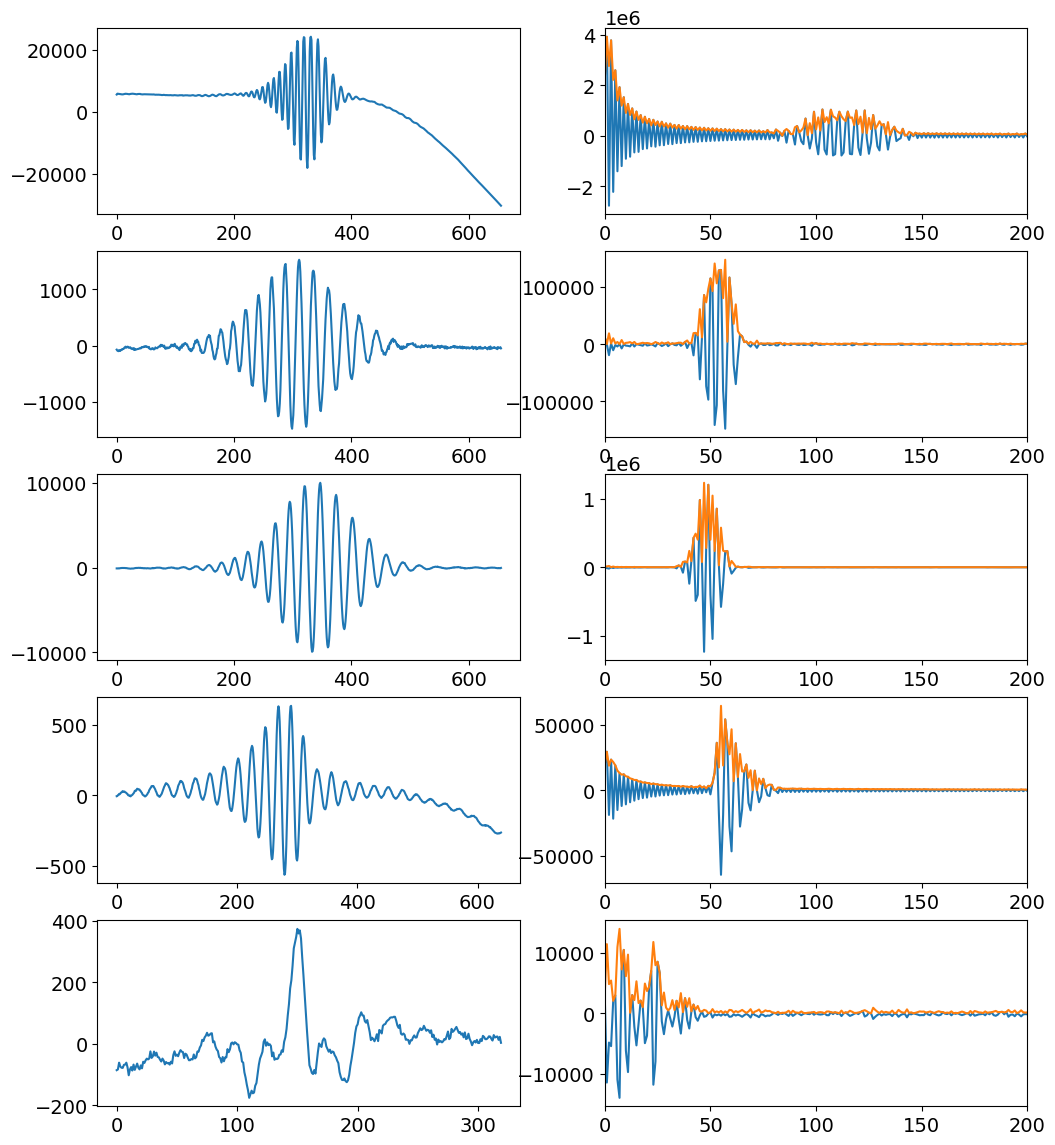

In [12]:
fig, axs = plt.subplots(5,2, figsize= (12,14))

axs[0][0].plot(fringes1)
axs[0][1].plot(fft1)
axs[0][1].plot(np.abs(fft1))
axs[0][1].set(xlim= (0,200))

axs[1][0].plot(fringes2)
axs[1][1].plot(fft2)
axs[1][1].plot(np.abs(fft2))
axs[1][1].set(xlim= (0,200))

axs[2][0].plot(fringes3)
axs[2][1].plot(fft3)
axs[2][1].plot(np.abs(fft3))
axs[2][1].set(xlim= (0,200))

axs[3][0].plot(fringes4)
axs[3][1].plot(fft4)
axs[3][1].plot(np.abs(fft4))
axs[3][1].set(xlim= (0,200))

axs[4][0].plot(fringes5)
axs[4][1].plot(fft5)
axs[4][1].plot(np.abs(fft5))
axs[4][1].set(xlim= (0,200))

plt.show()

In [16]:
fringes4.dtype

dtype('float64')

In [14]:
fringes1.tofile("C:\\Users\\syf83691\\OneDrive - Science and Technology Facilities Council\\Documents\\python\\compressed_sensing\\data\\ir1_processed")
fringes2.tofile("C:\\Users\\syf83691\\OneDrive - Science and Technology Facilities Council\\Documents\\python\\compressed_sensing\\data\\ir2_processed")
fringes3.tofile("C:\\Users\\syf83691\\OneDrive - Science and Technology Facilities Council\\Documents\\python\\compressed_sensing\\data\\ir3_processed")
fringes4.tofile("C:\\Users\\syf83691\\OneDrive - Science and Technology Facilities Council\\Documents\\python\\compressed_sensing\\data\\big13_processed")
fringes5.tofile("C:\\Users\\syf83691\\OneDrive - Science and Technology Facilities Council\\Documents\\python\\compressed_sensing\\data\\big18_processed")

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


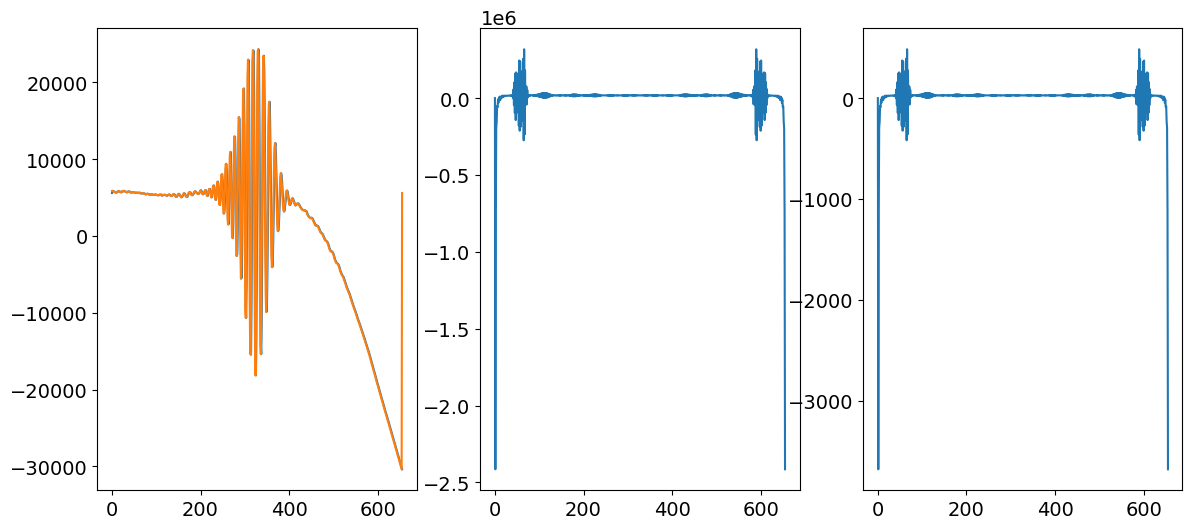

In [15]:
fig, axs = plt.subplots(1,3, figsize= (14,6))

axs[0].plot(fringes1)
axs[1].plot(np.fft.fft(fringes1))
axs[2].plot(np.fft.ifft(fringes1))
axs[0].plot(np.fft.fft(np.fft.fft(fringes1, norm="ortho"), norm="ortho")[::-1]) #WHAT? HOW????

plt.show()